# Validation of FWF distribution runs

In [1]:
import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 

import warnings
warnings.filterwarnings('ignore') #ignoring 10% trash warning

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

In [2]:
## once you've set up a dask-worker, connect to it, click the dashboard link to check worker status
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34633,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:41139,Total threads: 4
Dashboard: http://127.0.0.1:43693/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:42605,


In [3]:
temporary_db='/home/156/wf4500/databases/access/temporary_DSW.db'

session = cc.database.create_session(temporary_db)
expt_FW = 'ryf_FWFdist'
expt_CTRL = '01deg_jra55v13_ryf9091_21mbath'

In [4]:
lat_slice=slice(-90,-50)

In [5]:
tarea_FW = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf_FWFdist/archive/output000/ocean/ocean_grid.nc').area_t.sel(yt_ocean=lat_slice)

0.3.0


In [24]:
Importing vars for validation

wfiform_FW = cc.querying.getvar(expt_FW, 'wfiform', session, frequency='1 monthly').sel(yt_ocean=lat_slice)
wfiform_CTRL = cc.querying.getvar(expt_CTRL, 'wfiform', session, frequency='1 monthly').sel(yt_ocean=lat_slice)

dzt_FW = cc.querying.getvar(expt_FW, 'dzt', session, frequency='1 monthly').sel(yt_ocean=lat_slice)
dzt_CTRL = cc.querying.getvar(expt_CTRL, 'dzt', session, frequency='1 monthly').sel(yt_ocean=lat_slice)


SST_FW = cc.querying.getvar(expt_FW, 'temp', session, frequency='1 monthly').isel(st_ocean=0).sel(yt_ocean=lat_slice)- 273.15
SST_CTRL = cc.querying.getvar(expt_CTRL, 'temp', session, frequency='1 monthly').isel(st_ocean=0).sel(yt_ocean=lat_slice) - 273.15

brine2d_FW = cc.querying.getvar(expt_FW, 'brine_fwflx2d', session, frequency='1 monthly').sel(yt_ocean=lat_slice)
brine3d_FW = cc.querying.getvar(expt_FW, 'brine_fwflx', session, frequency='1 monthly').sel(yt_ocean=lat_slice)

SyntaxError: invalid syntax (3028743444.py, line 1)

In [10]:
brine2d_FW

<xarray.DataArray 'brine_fwflx2d' (time: 14, yt_ocean: 666, xt_ocean: 3600)>
dask.array<getitem, shape=(14, 666, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03
  * time      (time) object 1900-01-16 12:00:00 ... 1901-02-15 00:00:00
Attributes:
    long_name:      2d mass flux of liquid brine meltwater leaving ocean
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux2d_out_sea_water_from_brine_melting
    ncfiles:        ['/scratch/v45/wf4500/simulations/RYF_1mtop_FWFdist/wf450...

In [11]:
brine3d_FW 

<xarray.DataArray 'brine_fwflx' (time: 14, st_ocean: 75, yt_ocean: 666,
                                 xt_ocean: 3600)>
dask.array<getitem, shape=(14, 75, 666, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1900-01-16 12:00:00 ... 1901-02-15 00:00:00
Attributes:
    long_name:      3d mass flux of liquid brine meltwater leaving ocean
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux3d_out_sea_water_from_brine_melting
    ncfiles:        ['/scratch/v45/wf4500/simulations/RYF_1mtop_FWFdist/wf450...

In [12]:
#converting brine2 and 3 into double for higher precision calculations
brine2d_FW = brine2d_FW.astype('float64')
brine3d_FW = brine3d_FW.astype('float64')
brine3d_FW 

<xarray.DataArray 'brine_fwflx' (time: 14, st_ocean: 75, yt_ocean: 666,
                                 xt_ocean: 3600)>
dask.array<astype, shape=(14, 75, 666, 3600), dtype=float64, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1900-01-16 12:00:00 ... 1901-02-15 00:00:00
Attributes:
    long_name:      3d mass flux of liquid brine meltwater leaving ocean
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux3d_out_sea_water_from_brine_melting
    ncfiles:        ['/scratch/v45/wf4500/simulations/RYF_1mtop_FWFdist/wf450...

**check 1...** does wfiform equals brine2d?

Text(0.5, 1.0, 'spatial-mean fluxes')

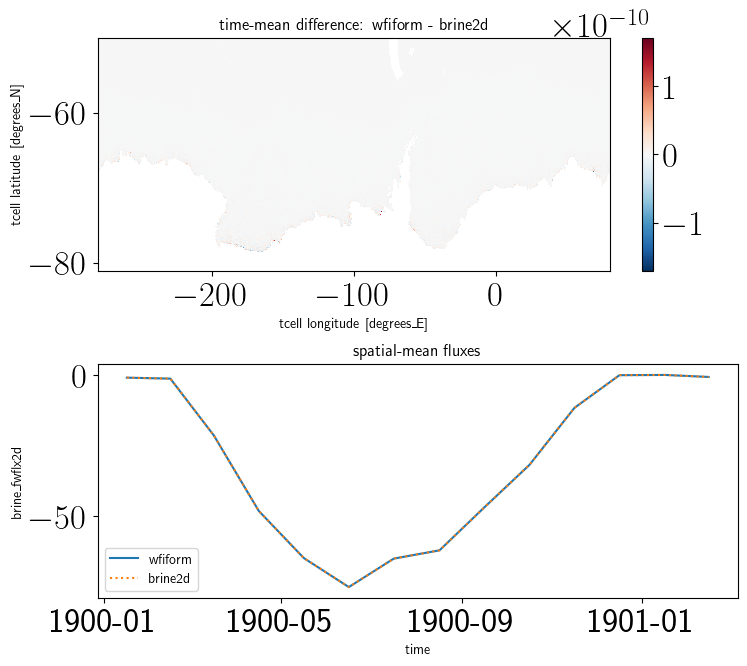

In [13]:
fig = plt.figure(figsize=(8,7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.subplot(2,1,1)
(wfiform_FW.mean('time') - brine2d_FW.mean('time')).plot()
plt.title('time-mean difference: wfiform - brine2d')

plt.subplot(2,1,2)
wfiform_FW.sum(('yt_ocean','xt_ocean')).plot(label='wfiform')
brine2d_FW.sum(('yt_ocean','xt_ocean')).plot(linestyle=':',label='brine2d')
plt.legend()
plt.title('spatial-mean fluxes')

**check 2...** does the vertical sum of brine3d = brine2d

Text(0.5, 1.0, '[b] S.O. temporal mean, $\\sum (z)$ Brine3d $+$ Brine2d')

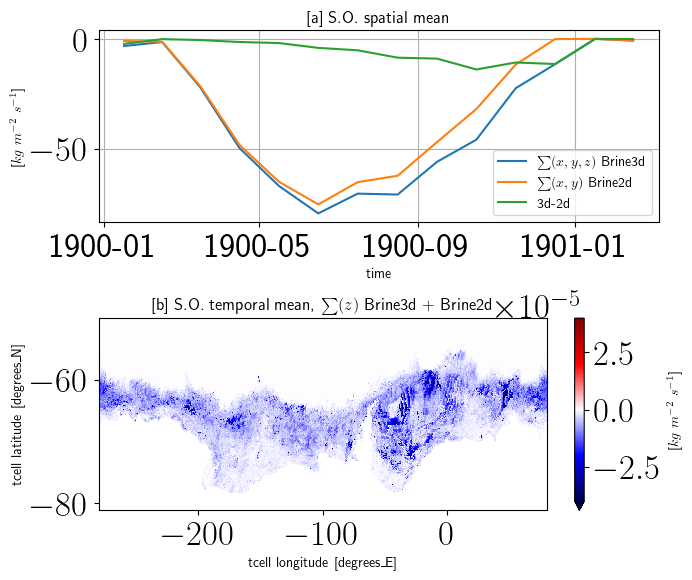

In [16]:
fig = plt.figure(figsize=(7,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

plt.subplot(2,1,1) # #Brine difference between 3d and 2d vars in kg/m2/s
(brine3d_FW).sum('st_ocean').sum(('xt_ocean','yt_ocean')).plot(label=r'$\sum (x,y,z)$ Brine3d')
(brine2d_FW).sum(('yt_ocean','xt_ocean')).plot(label='$\sum (x,y)$ Brine2d')
((brine3d_FW).sum('st_ocean').sum(('xt_ocean','yt_ocean')) - (brine2d_FW).sum(('yt_ocean','xt_ocean'))).plot(label='3d-2d')
plt.grid(); plt.ylabel(r'[$kg\ m^{-2}\ s^{-1}$]')
plt.legend(); plt.title('[a] S.O. spatial mean')

plt.subplot(2,1,2) # temporal mean anomalies
((brine3d_FW).sum('st_ocean').mean('time') - (brine2d_FW).mean('time')).plot.pcolormesh(cmap='seismic',vmin=-4e-5,vmax=4e-5,cbar_kwargs={'label': r"[$kg\ m^{-2}\ s^{-1}$]"})
plt.title(r'[b] S.O. temporal mean, $\sum (z)$ Brine3d $+$ Brine2d')


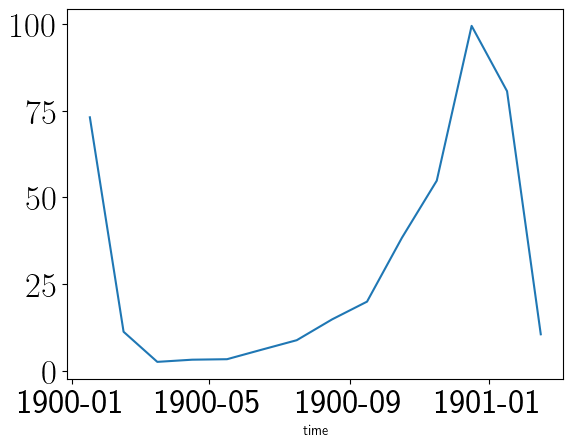

In [17]:
#Difference in percentage of brine3d
brine_error = (((brine3d_FW*tarea_FW).sum(('xt_ocean','yt_ocean')).sum('st_ocean') \
    - (brine2d_FW*tarea_FW).sum(('yt_ocean','xt_ocean'))) / \
      ((brine3d_FW*tarea_FW).sum(('xt_ocean','yt_ocean')).sum('st_ocean')) )*100


brine_error.plot()


In [18]:
#getting the depth on the bottom
zu_FW = brine3d_FW.st_ocean + (dzt_FW.mean(('xt_ocean','yt_ocean','time'))/2).load()
brine3d_FWzu =brine3d_FW.copy()
brine3d_FWzu['st_ocean']=zu_FW

(0.5, 8.0)

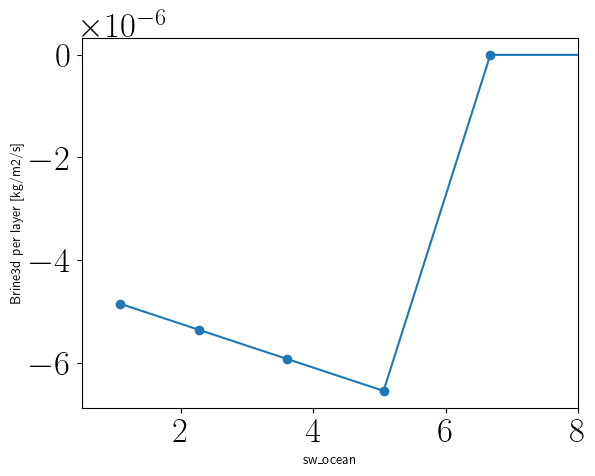

In [19]:
#plotting the brine
brine3d_FWzu.mean(['xt_ocean','yt_ocean','time']).rename({'st_ocean':'sw_ocean'}).plot(marker='o')
plt.ylabel('Brine3d per layer [kg/m2/s]')
plt.xlim(0.5,8)


In [20]:
### Importing double data for November and December. This is a rerun of nov/december, with brine diags saved in double precision
brine2d_double = xr.open_dataset('/scratch/v45/wf4500/simulations/RYF_1mtop_DECFWFdist/wf4500/access-om2/archive/ryf_DECFWFdist/output010/ocean/ocean_monthly_2d_basal.nc').brine_fwflx2d.sel(yt_ocean=lat_slice)
brine3d_double = xr.open_dataset('/scratch/v45/wf4500/simulations/RYF_1mtop_DECFWFdist/wf4500/access-om2/archive/ryf_DECFWFdist/output010/ocean/ocean_monthly_3d_basal.nc').brine_fwflx.sel(yt_ocean=lat_slice)


precision sanity check

In [21]:
brine2d_double 

<xarray.DataArray 'brine_fwflx2d' (time: 2, yt_ocean: 666, xt_ocean: 3600)>
[4795200 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03
  * time      (time) object 1900-11-16 00:00:00 1900-12-16 12:00:00
Attributes:
    long_name:      2d mass flux of liquid brine meltwater leaving ocean
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux2d_out_sea_water_from_brine_melting

In [22]:
brine3d_double 

<xarray.DataArray 'brine_fwflx' (time: 2, st_ocean: 75, yt_ocean: 666,
                                 xt_ocean: 3600)>
[359640000 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.16 -50.09 -50.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1900-11-16 00:00:00 1900-12-16 12:00:00
Attributes:
    long_name:      3d mass flux of liquid brine meltwater leaving ocean
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_flux3d_out_sea_water_from_brine_melting

Text(0.5, 1.0, '[b] S.O. temporal mean, $\\sum (z)$ Brine3d $+$ Brine2d: double')

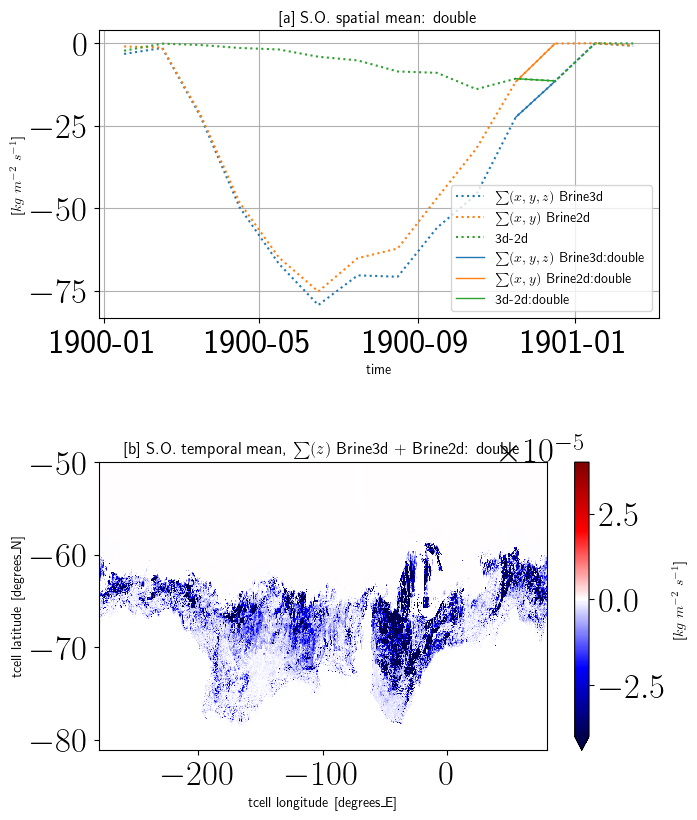

In [23]:
fig = plt.figure(figsize=(7,9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

plt.subplot(2,1,1) # #Brine difference between 3d and 2d vars in kg/m2/s
(brine3d_FW).sum(('xt_ocean','yt_ocean')).sum('st_ocean').plot(linestyle=':',label=r'$\sum (x,y,z)$ Brine3d')
(brine2d_FW).sum(('yt_ocean','xt_ocean')).plot(linestyle=':',label='$\sum (x,y)$ Brine2d')
((brine3d_FW).sum(('xt_ocean','yt_ocean')).sum('st_ocean') - (brine2d_FW).sum(('yt_ocean','xt_ocean'))).plot(linestyle=':',label='3d-2d')


(brine3d_double).sum(('xt_ocean','yt_ocean')).sum('st_ocean').plot(color='tab:blue',linewidth=1,label=r'$\sum (x,y,z)$ Brine3d:double')
(brine2d_double).sum(('yt_ocean','xt_ocean')).plot(color='tab:orange',linewidth=1,label='$\sum (x,y)$ Brine2d:double')
((brine3d_double).sum(('xt_ocean','yt_ocean')).sum('st_ocean') - (brine2d_double).sum(('yt_ocean','xt_ocean'))).plot(color='tab:green',linewidth=1,label='3d-2d:double')
plt.grid(); plt.ylabel(r'[$kg\ m^{-2}\ s^{-1}$]')
plt.legend(); plt.title('[a] S.O. spatial mean: double')

plt.subplot(2,1,2) # temporal mean anomalies
((brine3d_double).sum('st_ocean').mean('time') - (brine2d_double).mean('time')).plot.pcolormesh(cmap='seismic',vmin=-4e-5,vmax=4e-5,cbar_kwargs={'label': r"[$kg\ m^{-2}\ s^{-1}$]"})
plt.title(r'[b] S.O. temporal mean, $\sum (z)$ Brine3d $+$ Brine2d: double')
